<a href="https://colab.research.google.com/github/Rishabh763/SIP-Project/blob/main/SIP_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

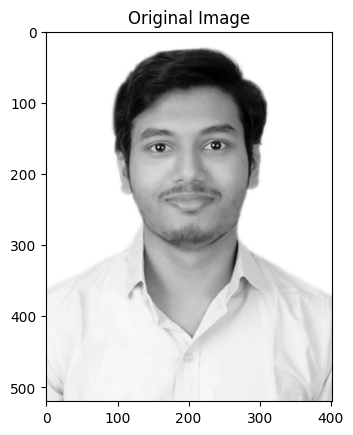

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Read image (grayscale)
img = cv2.imread('Rishabh_Photo.jpg', cv2.IMREAD_GRAYSCALE)
plt.imshow(img, cmap='gray')
plt.title('Original Image')
plt.show()

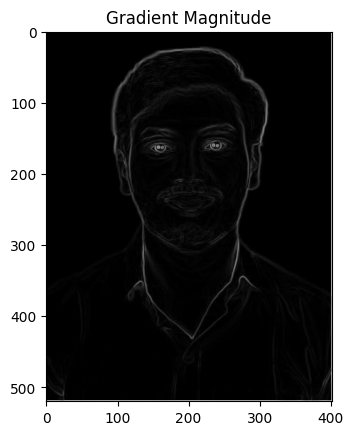

In [ ]:
# Define Sobel kernels
sobel_x = np.array([[-1, 0, 1],
                    [-2, 0, 2],
                    [-1, 0, 1]])
sobel_y = np.array([[-1, -2, -1],
                    [0, 0, 0],
                    [1, 2, 1]])

def convolve2d(image, kernel):
    h, w = image.shape
    kh, kw = kernel.shape
    pad_h, pad_w = kh // 2, kw // 2
    padded = np.pad(image, ((pad_h, pad_h), (pad_w, pad_w)), mode='constant')
    result = np.zeros_like(image, dtype=float)
    for i in range(h):
        for j in range(w):
            region = padded[i:i+kh, j:j+kw]
            result[i, j] = np.sum(region * kernel)
    return result

# Compute gradients
gx = convolve2d(img, sobel_x)
gy = convolve2d(img, sobel_y)
gradient_magnitude = np.sqrt(gx**2 + gy**2)

plt.imshow(gradient_magnitude, cmap='gray')
plt.title('Gradient Magnitude')
plt.show()

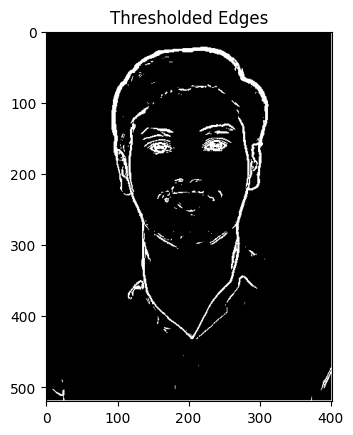

In [ ]:
threshold = 100  # You can adjust this value
binary_edges = (gradient_magnitude > threshold).astype(np.uint8) * 255
plt.imshow(binary_edges, cmap='gray')
plt.title('Thresholded Edges')
plt.show()


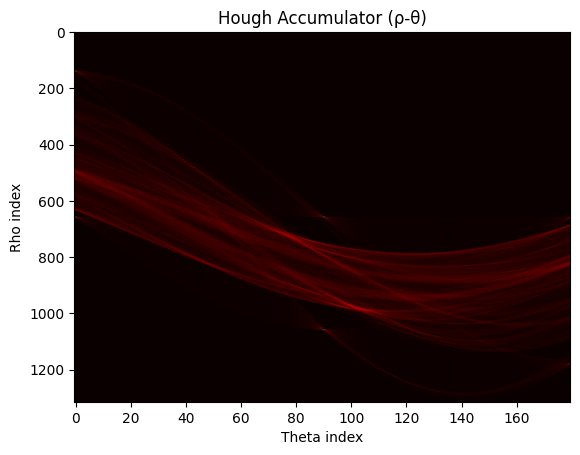

In [ ]:
height, width = binary_edges.shape
max_dist = int(np.hypot(height, width))
rhos = np.arange(-max_dist, max_dist + 1, 1)
thetas = np.deg2rad(np.arange(-90, 90))
accumulator = np.zeros((len(rhos), len(thetas)), dtype=np.uint64)

y_idxs, x_idxs = np.nonzero(binary_edges)
for i in range(len(x_idxs)):
    x = x_idxs[i]
    y = y_idxs[i]
    for t_idx in range(len(thetas)):
        theta = thetas[t_idx]
        rho = int(round(x * np.cos(theta) + y * np.sin(theta)))
        rho_idx = rho + max_dist
        accumulator[rho_idx, t_idx] += 1

plt.imshow(accumulator, cmap='hot', aspect='auto')
plt.title('Hough Accumulator (\u03c1-\u03b8)')
plt.xlabel('Theta index')
plt.ylabel('Rho index')
plt.show()


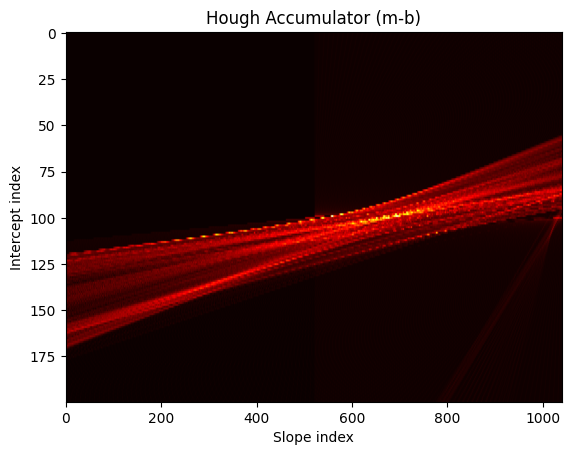

In [ ]:
# Define range for slopes (avoid vertical lines for simplicity)
min_slope, max_slope = -10, 10
num_slopes = 200
slopes = np.linspace(min_slope, max_slope, num_slopes)
intercepts = np.arange(-height, height)
acc_mb = np.zeros((len(slopes), len(intercepts)), dtype=np.uint64)

for i in range(len(x_idxs)):
    x = x_idxs[i]
    y = y_idxs[i]
    for s_idx, m in enumerate(slopes):
        b = int(round(y - m * x))
        b_idx = b + height  # shift to positive index
        if 0 <= b_idx < len(intercepts):
            acc_mb[s_idx, b_idx] += 1

plt.imshow(acc_mb, cmap='hot', aspect='auto')
plt.title('Hough Accumulator (m-b)')
plt.xlabel('Slope index')
plt.ylabel('Intercept index')
plt.show()


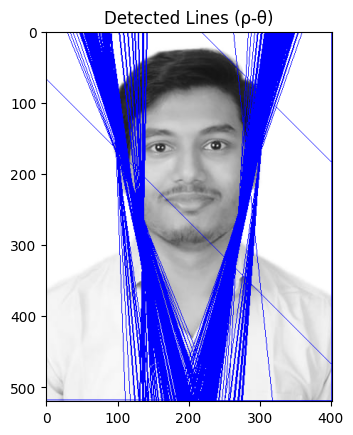

In [ ]:
# Find peaks in accumulator (simple thresholding)
threshold_votes = 100  # Adjust as needed
lines = np.argwhere(accumulator > threshold_votes)
img_lines = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
for rho_idx, theta_idx in lines:
    rho = rhos[rho_idx]
    theta = thetas[theta_idx]
    a = np.cos(theta)
    b = np.sin(theta)
    x0 = a * rho
    y0 = b * rho
    x1 = int(x0 + 1000 * (-b))
    y1 = int(y0 + 1000 * (a))
    x2 = int(x0 - 1000 * (-b))
    y2 = int(y0 - 1000 * (a))
    cv2.line(img_lines, (x1, y1), (x2, y2), (0, 0, 255), 1)

plt.imshow(img_lines)
plt.title('Detected Lines (\u03c1-\u03b8)')
plt.show()